## Example plot for LFPy: Single-synapse contribution to the potential through head
* https://github.com/LFPy/LFPy/blob/master/examples/example_ECoG_4sphere.py
```
Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
```

In [19]:
import LFPy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from os.path import join
%matplotlib inline

In [20]:
# four-sphere properties
radii = [79000., 80000., 85000., 90000.]
radii_name = ["Brain", "CSF", "Skull", "Scalp"]
sigmas = [0.3, 1.5, 0.015, 0.3]
rad_tol = 1e-2
somapos = np.array([0., 0., 78750.])

xlim = [-1000, 1000]
ylim = [radii[0] - 500, radii[1] + 500]

In [21]:

# cell with simplified morphology
cellParameters = {
    'morphology': join("morphologies", 'example_morphology.hoc'),
    'tstart': 0.,
    'tstop': 5.,
    'dt': 2**-4,
    'v_init': -65,
    'cm': 1.,
    'Ra': 150.,
    'passive': True,
    'passive_parameters': {'g_pas': 1. / 3E4, 'e_pas': -65.},
    'pt3d': True,
}

In [22]:
cell = LFPy.Cell(**cellParameters)
synidx = cell.get_closest_idx(z=200)

In [23]:

synapseParameters = {
    'idx': synidx,
    'e': 0,                                # reversal potential
    'syntype': 'Exp2Syn',                   # synapse type
    'tau1': 0.1,                              # syn. rise time constant
    'tau2': 1.,                              # syn. decay time constant
    'weight': 0.002,                        # syn. weight
    'record_current': True                 # syn. current record
}

In [24]:
synapse = LFPy.Synapse(cell, **synapseParameters)
synapse.set_spike_times(np.array([1.]))
cell.set_pos(z=somapos[2])
cell.simulate(rec_imem=True, rec_vmem=True)

In [25]:

# Setting up recording positions
elec_z = np.array([radii[0],
                   (radii[0] + radii[1]) / 2,
                   radii[1],
                   radii[1] + 500])

elec_x = np.zeros(elec_z.shape)
elec_y = np.zeros(elec_x.shape)
eeg_coords = np.array([elec_x.flatten(), elec_y.flatten(), elec_z.flatten()]).T


In [26]:

MD_4s = LFPy.FourSphereVolumeConductor(eeg_coords, radii, sigmas)
phi = MD_4s.get_dipole_potential_from_multi_dipoles(cell) * 1e6  # mV to nV

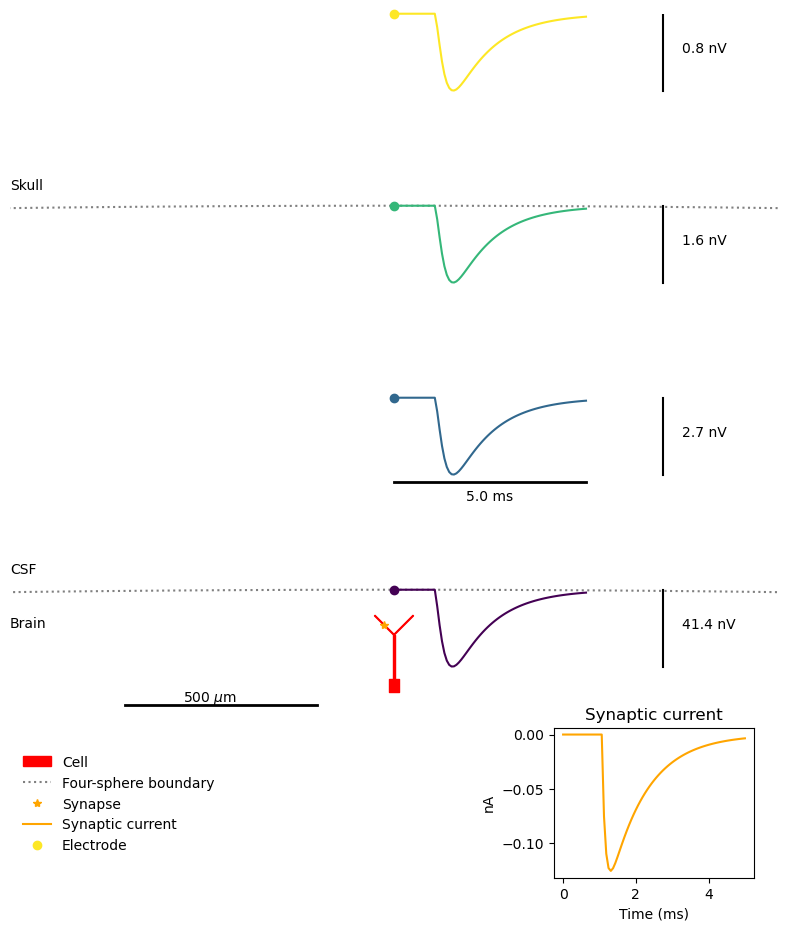

In [27]:

# Plotting results
plt.close('all')
fig = plt.figure(figsize=[8, 10])
fig.subplots_adjust(left=0.02, hspace=0.5, right=0.98, top=0.95)

ax = fig.add_subplot(111, aspect=1, frameon=False, xlim=xlim, ylim=ylim,
                     xticks=[], yticks=[])

# Plotting cell
zips = []
for x, z in cell.get_pt3d_polygons(projection=('x', 'z')):
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='r',
                         facecolors='r')
l_cell = ax.add_collection(polycol)


l_syn, = ax.plot(synapse.x, synapse.z,
                 '*', c='orange', zorder=5,
                 label="Synapse")

# Plotting the layers of the head model
max_angle = np.abs(np.rad2deg(np.arcsin(xlim[0] / ylim[0])))
plot_angle = np.linspace(-max_angle, max_angle, 100)
for b_idx in range(len(radii)):
    x_ = radii[b_idx] * np.sin(np.deg2rad(plot_angle))
    z_ = radii[b_idx] * np.cos(np.deg2rad(plot_angle))
    l_curved, = ax.plot(x_, z_, ':', c="gray", label="Four-sphere boundary")

ax.text(xlim[0], radii[0] - 70, "Brain", va="top", ha="left", color="k")
ax.text(xlim[0], radii[0] + 70, "CSF", va="top", ha="left", color="k")
ax.text(xlim[0], radii[1] + 70, "Skull", va="top", ha="left", color="k")

ax.plot([-700, -200], [radii[0] - 300, radii[0] - 300], 'k', lw=2)
ax.text(-550, radii[0] - 290, r"500 $\mu$m")

# Plotting the potential at different positions
y_norm = 200
x_norm = 500


def elec_clr(elec_idx):
    return plt.cm.viridis(elec_idx / (len(elec_z) - 1))


for elec_idx in range(len(elec_z)):
    l_elec, = ax.plot(elec_x[elec_idx], elec_z[elec_idx],
                      'o', c=elec_clr(elec_idx), clip_on=False,
                      label="Electrode")
    y_ = phi[elec_idx, :]
    norm_const = np.max(np.abs(y_))
    y_ = y_ * y_norm / norm_const + elec_z[elec_idx]
    x_ = cell.tvec / cell.tvec[-1] * x_norm + elec_x[elec_idx]
    ax.plot(x_, y_, c=elec_clr(elec_idx), clip_on=False)
    ax.plot([x_[-1] + 200, x_[-1] + 200],
            [elec_z[elec_idx], elec_z[elec_idx] - y_norm], c='k')
    scale_text = "{:2.1f} nV".format(norm_const)
    ax.text(x_[-1] + 250, elec_z[elec_idx] - y_norm / 2, scale_text)

ax.plot([x_[0], x_[-1]],
        [elec_z[1] - y_norm * 1.1, elec_z[1] - y_norm * 1.1],
        c='k', clip_on=False, lw=2)
ax.text((x_[0] + x_[-1]) / 2, elec_z[1] - y_norm * 1.2,
        "{} ms".format(cell.tvec[-1]),
        va="top", ha="center", clip_on=False)

ax_inset = fig.add_axes([0.7, 0.05, 0.25, 0.15], title="Synaptic current",
                        ylabel="nA", xlabel="Time (ms)")
l_isyn, = ax_inset.plot(cell.tvec, synapse.i, c='orange',
                        label="Synaptic current")

ax.legend([l_cell, l_curved, l_syn, l_isyn, l_elec],
          ["Cell", "Four-sphere boundary", "Synapse",
           "Synaptic current", "Electrode"],
          ncol=1, loc=(0.01, -0.1), frameon=False)

plt.savefig(join('example_potential_through_head.pdf'))
plt.show()
